**遷移學習：將A數據集訓練的神經網路，換用到B數據集上，而B數據集的神經網路「不可以」完全重新訓練。**

這裡我使用以下兩個tensorflow.keras.datasets經典的資料集來實作遷移學習：
* A數據集：cifar10
* B數據集：cifar100

 ## 1. 載入套件及資料集

In [1]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np

# Layers for FNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Layers for CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, Adam

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 2. 資料前處理

**讀取 CIFAR 10 資料集**

In [2]:
name_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Load CIFAR 10
(X_train, y_train0), (X_test, y_test0) = datasets.cifar10.load_data()

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

**查看資料集中隨機一張照片**

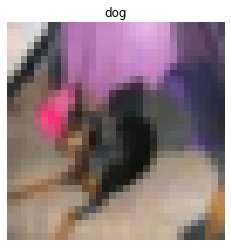

In [4]:
idx = np.random.randint(X_train.shape[0])
X_sample = X_train[idx]
y_sample = y_train0[idx].squeeze()

plt.imshow(X_sample)
plt.title(name_list[y_sample])
plt.axis('off');

## 3. 建立用於分類 CIFAR 10 的卷積神經網路

**打造神經網路**

這裡我使用Sequential另一種建立模型的方式(不用model.add)來打造神經網路，並且將CNN layers的部分拆開成兩個block(之後會有特殊用途)，從頭開始訓練一個用於分類 CIFAR 10 的卷積神經網路。

In [5]:
CNN_layers_block1 = [
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', name='block1_Conv_1'),
    MaxPool2D(),
    Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_Conv_2'),
    MaxPool2D()]

CNN_layers_block2 = [
    Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', name='block2_Conv_1'),
    MaxPool2D(),
    Conv2D(256, (3, 3), padding='same', activation='relu', name='block2_Conv_2'), 
    GlobalAveragePooling2D()]

FC_layers = [Dense(units=128, activation='relu'),
             Dense(units=10, activation='softmax')]

model = Sequential(CNN_layers_block1+CNN_layers_block2+FC_layers)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**查看模型架構**

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv_1 (Conv2D)       (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
block1_Conv_2 (Conv2D)       (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
block2_Conv_1 (Conv2D)       (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
block2_Conv_2 (Conv2D)       (None, 4, 4, 256)         2

**編譯模型**

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

**訓練模型**

In [8]:
model.fit(X_train, y_train, 
          batch_size=128, 
          epochs=10,
          validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 36s 730us/sample - loss: 1.6982 - categorical_accuracy: 0.3585 - val_loss: 1.4139 - val_categorical_accuracy: 0.4721
Epoch 2/10
50000/50000 [==============================] - 34s 687us/sample - loss: 1.3347 - categorical_accuracy: 0.5086 - val_loss: 1.2245 - val_categorical_accuracy: 0.5586
Epoch 3/10
50000/50000 [==============================] - 34s 676us/sample - loss: 1.1633 - categorical_accuracy: 0.5803 - val_loss: 1.0713 - val_categorical_accuracy: 0.6137
Epoch 4/10
50000/50000 [==============================] - 34s 677us/sample - loss: 1.0400 - categorical_accuracy: 0.6278 - val_loss: 1.0249 - val_categorical_accuracy: 0.6283
Epoch 5/10
50000/50000 [==============================] - 41s 820us/sample - loss: 0.9521 - categorical_accuracy: 0.6603 - val_loss: 0.9459 - val_categorical_accuracy: 0.6621
Epoch 6/10
50000/50000 [==============================] - 35s 709us/sample 

**查看 model 預測 CIFAR 10 的結果**

In [9]:
score_train = model.evaluate(X_train, y_train, batch_size=1024)
score_test = model.evaluate(X_test, y_test, batch_size=1024)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 3s 314us/sample - loss: 0.7484 - categorical_accuracy: 0.7453
Train Accuracy: 79.4260025024414
Test Accuracy: 74.52999949455261


**保存模型**

In [10]:
model.save('CIFAR10_CNN.h5')  

## 4. 透過遷移學習的方式建立用於分類 CIFAR 100 的卷積神經網路

**讀取 CIFAR 100 資料集，並進行資料前處理**

In [11]:
# Load CIFAR 100
(U_train, v_train0), (U_test, v_test0) = datasets.cifar100.load_data()

# Normalize the range of featurs
U_train = U_train / U_train.max()
U_test = U_test / U_test.max()

# One-hot encoding
v_train = to_categorical(v_train0, 100)
v_test = to_categorical(v_test0, 100)

169009152/169001437 [==============================] - 100s 1us/step


**打造神經網路**

這裡我用和第一個模型(model)相同的CNN layers建立一個用於分類 CIFAR 100 的卷積神經網路(model_CF100)，但是凍結(Frozen)剛剛model中第一個CNN block訓練好的參數，而全連結層的部分則換成層數更多的版本。

In [13]:
for layer in CNN_layers_block1:
    layer.trainable = False

In [14]:
FC_layers_CF100 = [Dense(units=128, activation='relu'),
                   Dense(units=128, activation='relu'),
                   Dense(units=100, activation='softmax')]

model_CF100 = Sequential(CNN_layers_block1+CNN_layers_block2+FC_layers_CF100)

**查看模型架構**

In [15]:
model_CF100.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv_1 (Conv2D)       (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
block1_Conv_2 (Conv2D)       (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
block2_Conv_1 (Conv2D)       (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
block2_Conv_2 (Conv2D)       (None, 4, 4, 256)        

由於我凍結了剛剛model中第一個CNN block訓練好的參數，因此出現19,392個「Non-trainable parameters」。

**編譯模型**

In [16]:
model_CF100.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])

**訓練模型**

In [17]:
model_CF100.fit(U_train, v_train,
                batch_size=128, 
                epochs=10,
                validation_data=(U_test, v_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 426us/sample - loss: 3.3658 - categorical_accuracy: 0.1835 - val_loss: 2.8549 - val_categorical_accuracy: 0.2753
Epoch 2/10
50000/50000 [==============================] - 22s 447us/sample - loss: 2.7113 - categorical_accuracy: 0.3027 - val_loss: 2.5890 - val_categorical_accuracy: 0.3337
Epoch 3/10
50000/50000 [==============================] - 26s 524us/sample - loss: 2.4866 - categorical_accuracy: 0.3498 - val_loss: 2.4643 - val_categorical_accuracy: 0.3629
Epoch 4/10
50000/50000 [==============================] - 27s 537us/sample - loss: 2.3305 - categorical_accuracy: 0.3848 - val_loss: 2.3638 - val_categorical_accuracy: 0.3778
Epoch 5/10
50000/50000 [==============================] - 26s 524us/sample - loss: 2.2048 - categorical_accuracy: 0.4107 - val_loss: 2.3129 - val_categorical_accuracy: 0.3926
Epoch 6/10
50000/50000 [==============================] - 28s 566us/sample 

**查看 model_CF100 預測 CIFAR 100 的結果**

In [19]:
score_train = model_CF100.evaluate(U_train, v_train, batch_size=1024)
score_test = model_CF100.evaluate(U_test, v_test, batch_size=1024)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 185us/sample - loss: 2.0853 - categorical_accuracy: 0.4507
Train Accuracy: 53.69600057601929
Test Accuracy: 45.07000148296356


基本上model_CF100的架構和model沒有太大的變化，但要分類的種類提升至100種，因此模型表現不好是預期之中的事。

**再看一次 model 預測 CIFAR 10 的結果**

In [31]:
score_train = model.evaluate(X_train, y_train, batch_size=1024)
score_test = model.evaluate(X_test, y_test, batch_size=1024)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 173us/sample - loss: 1.5928 - categorical_accuracy: 0.5989
Train Accuracy: 61.86000108718872
Test Accuracy: 59.89000201225281


咦？這個結果怎麼和原本對 CIFAR 100 實施遷移學習之前的 model 預測 CIFAR 10 的結果不同呢？

**讀取對 CIFAR 100 實施遷移學習之前就已經儲存的 model ，然後再看 model 預測 CIFAR 10 的結果**

In [29]:
from tensorflow.keras.models import load_model
model_original = load_model('CIFAR10_CNN.h5')

score_train = model_original.evaluate(X_train, y_train, batch_size=1024)
score_test = model_original.evaluate(X_test, y_test, batch_size=1024)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 2s 174us/sample - loss: 0.7484 - categorical_accuracy: 0.7453
Train Accuracy: 79.4260025024414
Test Accuracy: 74.52999949455261


原來，實施遷移學習之後，對於一開始用 CIFAR 10 建立的分類模型(model)來說，雖然我凍結了 model 中第一個CNN block中的參數，但是第二個CNN block中的參數在建立 CIFAR 100 分類模型的過程中又會繼續訓練，因此在對 CIFAR 100 實施遷移學習之後的 model 和原來 model 的預測結果會不一樣。

**保存模型**

In [21]:
model_CF100.save('CIFAR100_CNN_transfer_learning.h5')  